## Практическое задание

<ol>
    <li>Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 
    </li>

</ol>

## SPP-Net
<ol>
<li> Размеры каждого Proposal Region отличаются, если свертку картинки сделать всего один раз, мы сталкнемся с проблемой разницы замеров Region. Из-за разницы размеров, вход в полносвязном слой получится разных размеров. Нам надо применить SPP, пространственно пирамидальное обьединение, так  Region разного размера на выходе будут обладать одинакоым размером,что увеличит скорость и решит проблему разных размеров.
</li>
<li>
 в R-CNN сети заводятся картинки с фиксированным размером. По этому необходимо проводить crop, wrap изменения для сглаживания искажения вызванного размером. Кроме того для каждого предоложительной области (proposal) картинки небходимо собрать признаки, если на картинке будет один 1 млн, то мы будем извлекать признаки 1 млн раз для CNN, это несомненно очень время затратно.
</li>
<li>
SPP-Net усовершенствовала модель R-CNN. Основная мысль, даем на вход картинку и с целой картинки единожды генерируем признаки, после используем пространственные связи и из сгенерированных признаков, в пространственно пирамидальном обьединении генерируем доп. признаки.
</li>
<li>Мы отбросили crop/warp，решили проблему изменения картинок и как следствие потери информаци；
</li>
<li>пространственно пирамидальном обьединении  земестило на последий пулинговый слой.
</li>
</ol>

# 2.Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

In [ ]:
#Импорт всего

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from six import BytesIO
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


In [ ]:
from google.colab import files

In [ ]:
import cv2 as cv

In [ ]:
#Читаем картинку
im = cv.imread('1.png')

In [ ]:
im.shape[0]

900

In [ ]:
im.shape[1]

1200

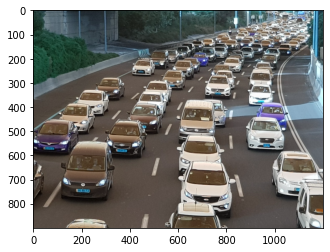

In [ ]:
plt.imshow(im)
plt.show()

## 1?
<p style='color: Green;'> 1? Правильно ли понимать что модель работает только с размерами 200 x 266 ? Если нет зачем делать ресайз?</p>


In [ ]:
newH = 200  #высота
newW = int(im.shape[1]*200/im.shape[0]) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 

In [ ]:
im.shape[0]

200

In [ ]:
im.shape[1]

266

In [ ]:
#Настройка модели
cv.setUseOptimized(True) #режим оптимизации
cv.setNumThreads(6)      #количество потоков

## 2?
<p style='color: Green;'>  
  Глупый вопрос, Что делать режим оптимизации и на что влияет кол-во потоков?
</p>



In [ ]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape) #число найденых объектов

(3700, 4)


## 3?
<p style='color: Green;'>  
  Это Selective Search Алгоритм с урока? switchToSelectiveSearchQuality - это работает как отброс того что является по его мнению низкопробными зонами?
</p>



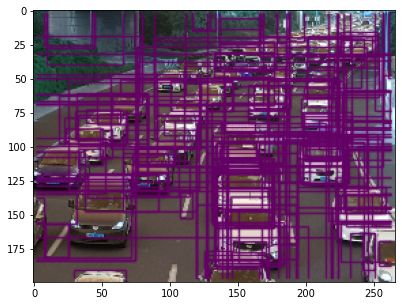

In [ ]:
#Построим области

num_Rects = 200 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for i, rect in enumerate(rects): 
  if (i < num_Rects): #пока не больше 
    # x,y - координаты левого верхнего угла; w, h - ширина и высота области
    x, y, w, h = rect
    # рисуем рамку      
    cv.rectangle(im_, (x, y), (x+w, y+h), (100, 0, 100), 1, cv.LINE_AA) 
  else: 
    break 

# Рисуем на экран
plt.figure(figsize=(16,5))
plt.imshow(im_) 
plt.show()

In [ ]:
# вывод картинки (типо как выше)
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [ ]:
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    # создаем временый файл
  _, filename = tempfile.mkstemp(suffix=".jpg")
  # Отправляем запрос по юрл адресу
  response = urlopen(url)
  # читаем ответ запроса
  image_data = response.read()
  # Почему мы делаем это через буфер байтов памяти?
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  # Если Тру выполняем функцию выше и выводим картинку.
  if display:
    display_image(pil_image)
  return filename

## 4?
<p style='color: Green;'>  
    Как рабоатет связка six.BytesIO и
PIL.Image ?
</p>



In [ ]:
#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

## 5?
<p style='color: Green;'>  
    Может забегая чуть чуть вперед , но мы уже передаем сюда значения рамок, где мы их берем? createSelectiveSearchSegmentation()?
</p>



In [ ]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=10)

  display_image(image_with_boxes)
  return result

## 6?
<p style='color: Green;'>  
tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...] - что означает ...  в [tf.newaxis, ...] ? - тензор.картинки.ковертируем_в_данные_(картинку, в терзор.флоат32)[тензорфлоу.новая_ось, все?]
</p>



In [ ]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [ ]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

In [ ]:
root_path = './' 

In [ ]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.png'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]



array('./1.png', dtype='<U7')

In [ ]:
List_name[0]

array('./1.png', dtype='<U7')

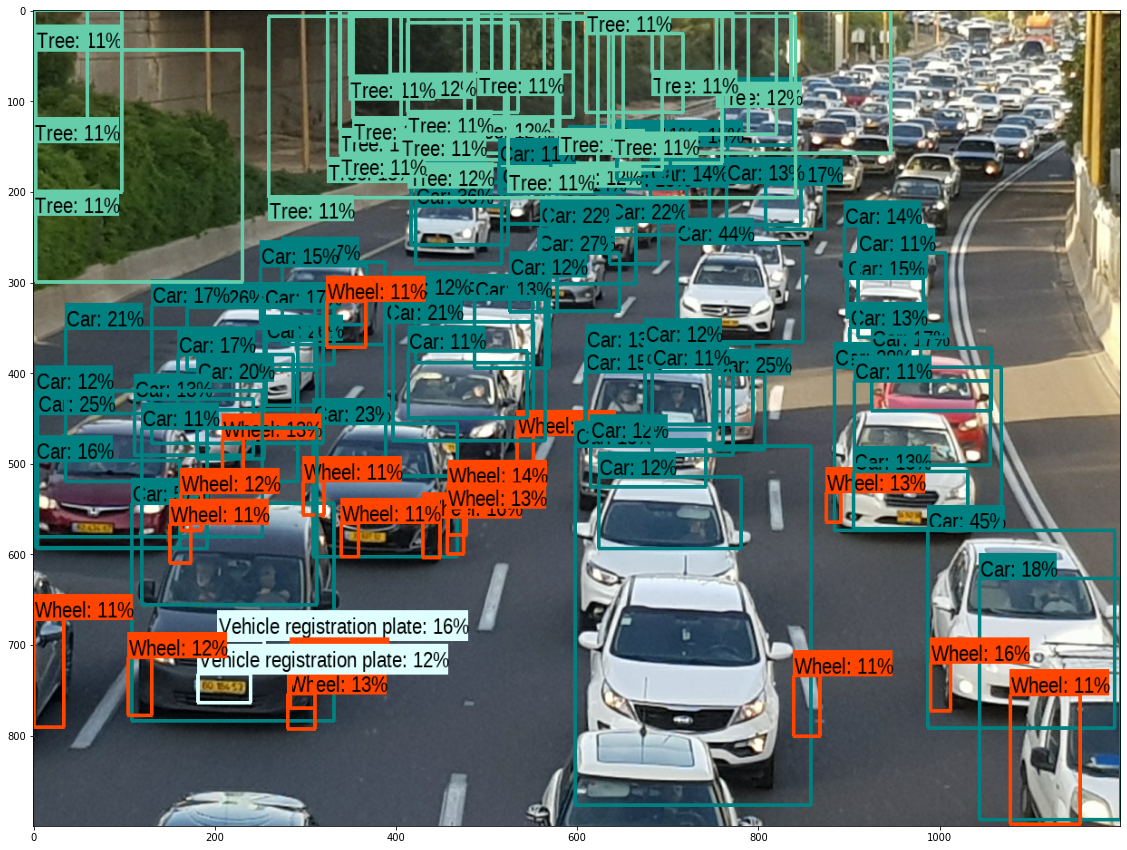

In [ ]:
result = run_detector(detector, List_name[0])

# вопросы
<ol>
<li style='color:#0001;'> 1? Правильно ли понимать что модель работает только с размерами 200 x 266 ? Если нет зачем делать ресайз?
</li>
<li style='color: Green;'>  
  Глупый вопрос, Что делать режим оптимизации и на что влияет кол-во потоков?
</li>
<li style='color: Green;'>  
  Это Selective Search Алгоритм с урока? switchToSelectiveSearchQuality - это работает как отброс того что является по его мнению низкопробными зонами?
</li>
<li style='color: red;'>  
    Как рабоатет связка six.BytesIO и
PIL.Image ?
</li>
<li style='color:Green;'>  
    Может забегая чуть чуть вперед , но мы уже передаем сюда значения рамок, где мы их берем? createSelectiveSearchSegmentation()?
</li>
<li style='color: Green;'>  
tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...] - что означает ...  в [tf.newaxis, ...] ? - тензор.картинки.ковертируем_в_данные_(картинку, в терзор.флоат32)[тензорфлоу.новая_ось, все?]
</li>
</ol>

In [ ]:

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=10)

  display_image(image_with_boxes)
  return result

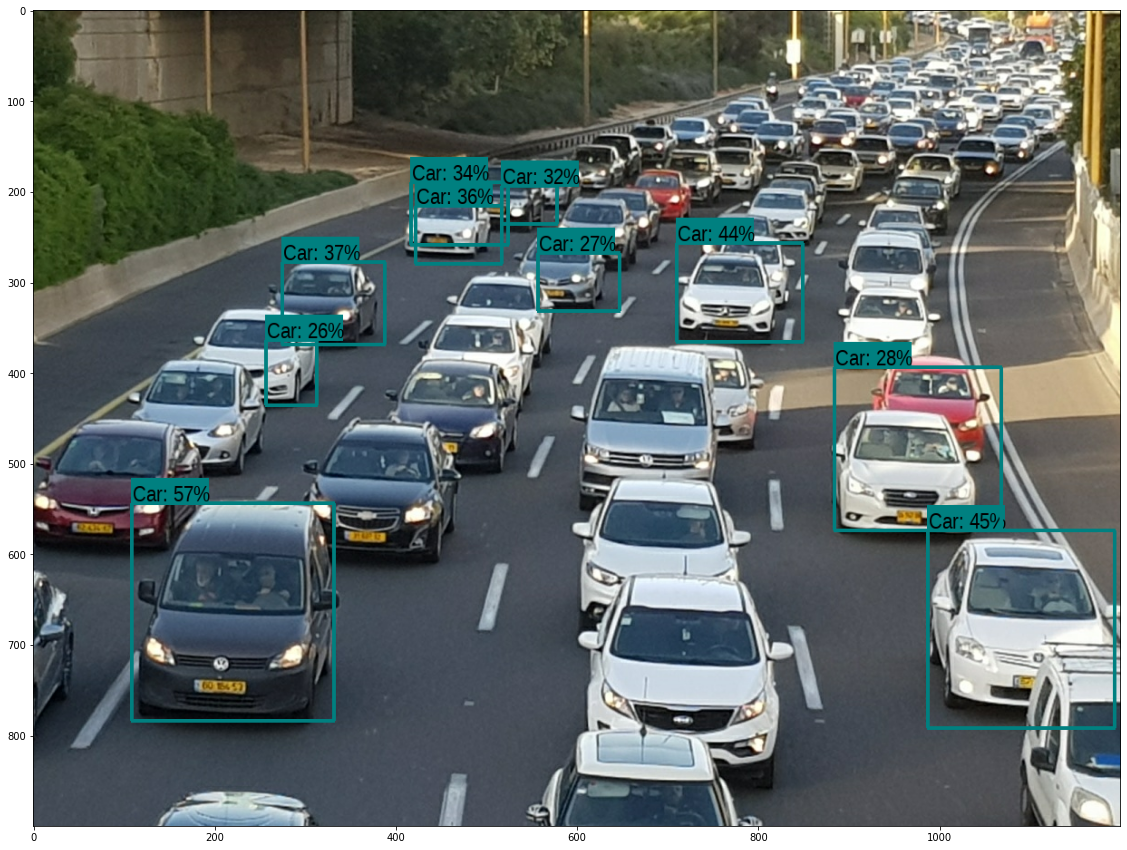

In [ ]:
result = run_detector(detector, List_name[0])